<function matplotlib.pyplot.show(close=None, block=None)>

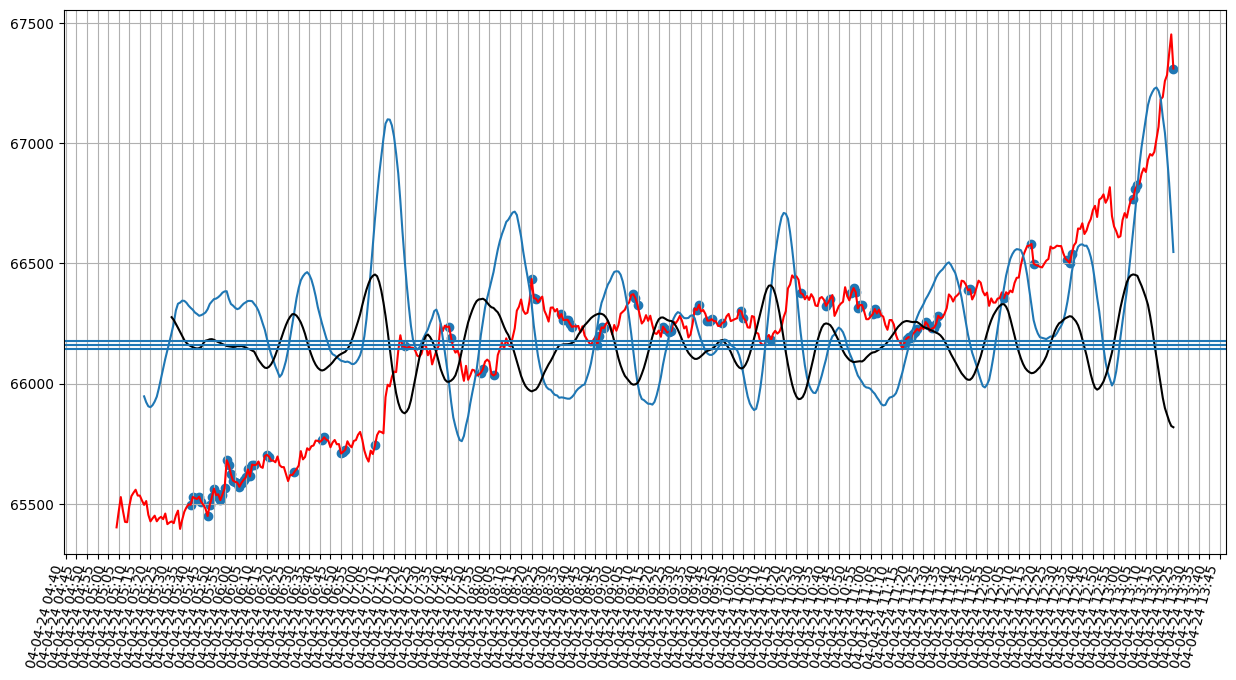

In [137]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Conexión con Binance para descargar la lista de pares que binance maneja
from binance import Client
client = Client()


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','1 day ago UTC'))
recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
#recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,25,3)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,25,3)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,25,3)
# recent_data


##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
a = 0
d = 500

min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[a:a+d].SD_Interpolacion.diff()
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.055) & (min_max_sd['Derivada'] <= 0.055)]
indices_min_max = lista_min_max.index.tolist()


######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
drlist = []
lista_min_max = lista_min_max.reset_index()
lista_min_max.columns = ['indice','Derivada']
mp = recent_data.Open[a:a+d].mean()


for i in range(1,len(lista_min_max)-1):
    if (lista_min_max.Derivada[i-1] >= lista_min_max.Derivada[i]) & (lista_min_max.Derivada[i+1] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[lista_min_max.indice[i]] < (mp - np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(lista_min_max.indice[i])
#        minlist.append(lista_min_max[i])
    elif (lista_min_max.Derivada[i-1] <= lista_min_max.Derivada[i]) & (lista_min_max.Derivada[i+1] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[lista_min_max.indice[i]] > (mp + np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(lista_min_max.indice[i])
#        maxlist.append(lista_min_max[i])


######################################################################
# Gráficas resultantes de los análisis anteriores.
######################################################################
# plt.axvline(halving_dates['Halving_Dates'][2])
# plt.axvline(halving_dates['Halving_Dates'][3])
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[a:a+d],recent_data.Open[a:a+d].multiply(1),color='red')
plt.plot(recent_data.Tiempo[a:a+d],recent_data.PD_Interpolacion[a:a+d].multiply(30)+mp)
plt.plot(recent_data.Tiempo[a:a+d],recent_data.SD_Interpolacion[a:a+d].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[indices_min_max],recent_data.Open.iloc[indices_min_max])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*10 + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*10)
# plt.axvline(6500)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

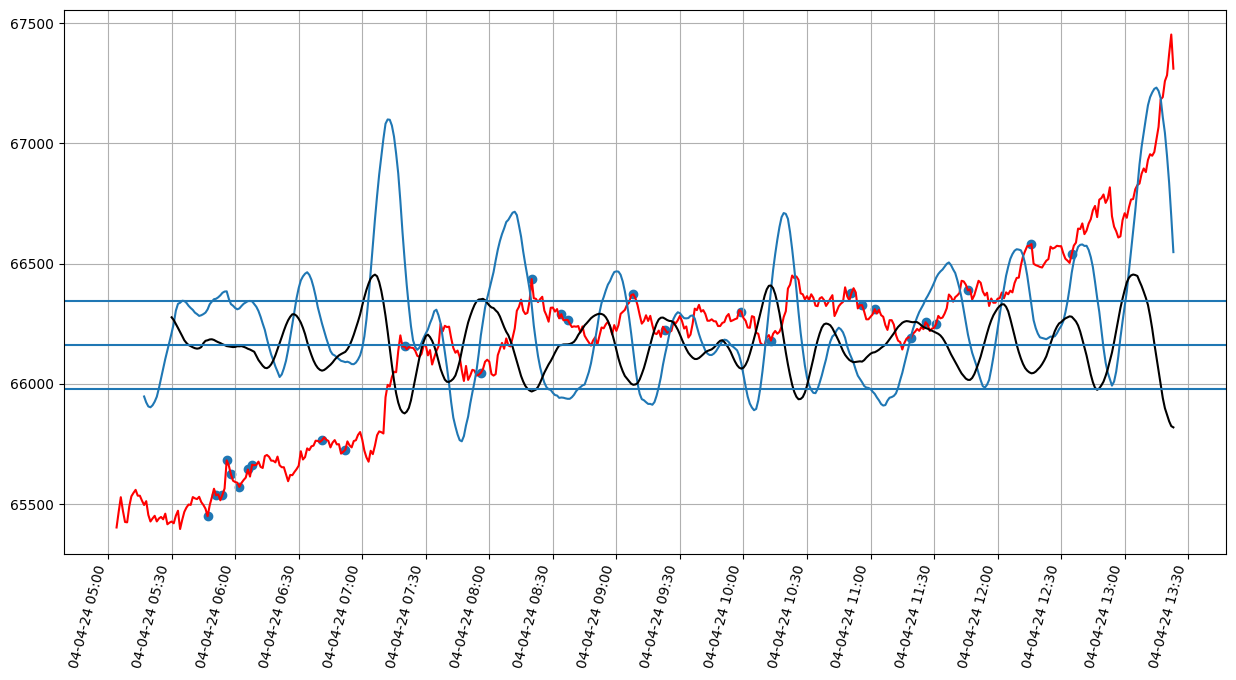

In [139]:
a = 0
d = 500

min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[a:a+d].SD_Interpolacion.diff()
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.2) & (min_max_sd['Derivada'] <= 0.2)]
lista_min_max = lista_min_max.index.tolist()

mp = recent_data.Open[a:a+d].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[a:a+d],recent_data.Open[a:a+d].multiply(1),color='red')
plt.plot(recent_data.Tiempo[a:a+d],recent_data.PD_Interpolacion[a:a+d].multiply(30)+mp)
plt.plot(recent_data.Tiempo[a:a+d],recent_data.SD_Interpolacion[a:a+d].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[drlist],recent_data.Open.iloc[drlist])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*100 + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*100)
# plt.axvline(6500)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

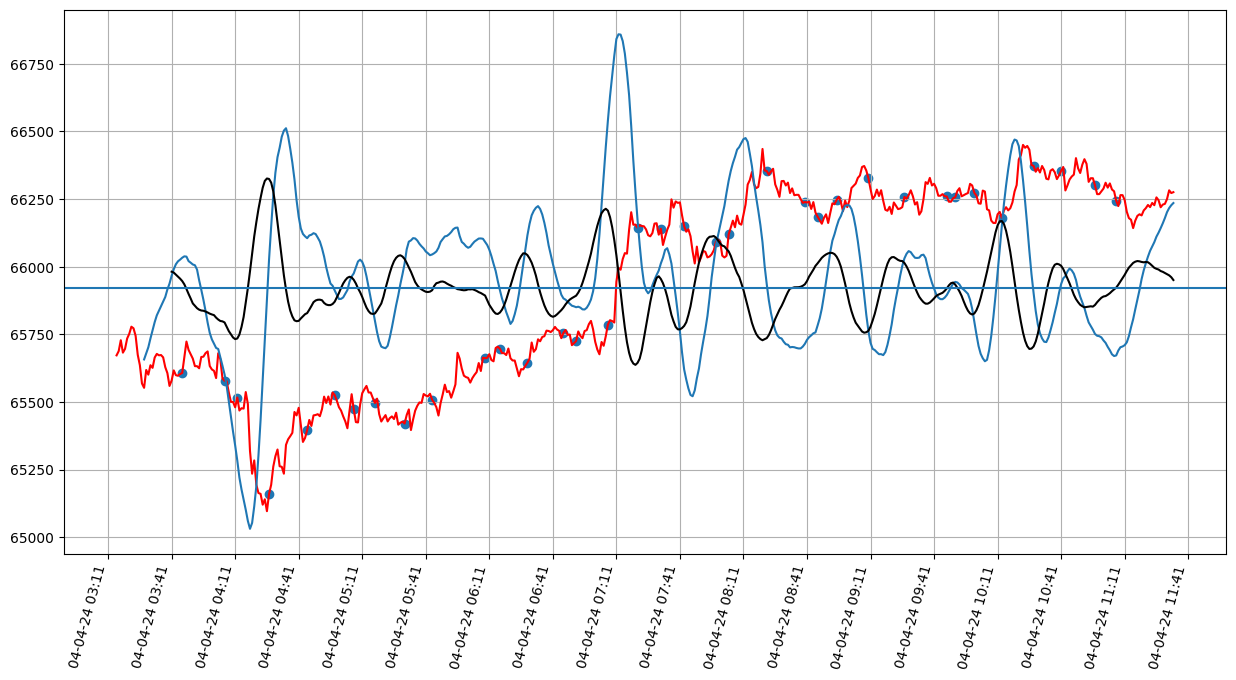

1217